# **Data Preparation and Analysis**

## Web API: News API
## Student Number: 21202384

In [1]:
# import needed libraies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import re # Regular expresson library
import json
import requests
import nltk

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load Data from disk
path='/content/gdrive/My Drive/News_Data_Merged (1).json' # path to saved file in disk
file=open(path,'rb') # Opens file path for reading
data=json.load(file) # Loads the Json Object from the open file path, Returns a string of the json object
print('Data is of format {}'.format(type(data)))

Data is of format <class 'dict'>


The Data Sources and News articles are both saved as a single json file with seperate dict keys.We clean the data seperately and merge them for analysis. 

In [4]:
# Getting data keys
data.keys()

dict_keys(['sources', 'articles'])

In [6]:
# A Peek into Data Source file
data['sources'][:3]

[{'category': 'general',
  'country': 'us',
  'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
  'id': 'abc-news',
  'language': 'en',
  'name': 'ABC News',
  'url': 'https://abcnews.go.com'},
 {'category': 'general',
  'country': 'au',
  'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
  'id': 'abc-news-au',
  'language': 'en',
  'name': 'ABC News (AU)',
  'url': 'http://www.abc.net.au/news'},
 {'category': 'general',
  'country': 'no',
  'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
  'id': 'aftenposten',
  'language': 'no',
  'name': 'Aftenposten',
  'url': 'https://www.aftenposten.no'}]

In [7]:
# Converting data sources into Pandas Dataframe format
source_data=pd.DataFrame(data['sources'])
source_data.head(5)

,id,name,description,url,category,language,country
0,abc-news,ABC News,"Your trusted source for breaking news, analysi...",https://abcnews.go.com,general,en,us
1,abc-news-au,ABC News (AU),"Australia's most trusted source of local, nati...",http://www.abc.net.au/news,general,en,au
2,aftenposten,Aftenposten,Norges ledende nettavis med alltid oppdaterte ...,https://www.aftenposten.no,general,no,no
3,al-jazeera-english,Al Jazeera English,"News, analysis from the Middle East and worldw...",http://www.aljazeera.com,general,en,us
4,ansa,ANSA.it,"Agenzia ANSA: ultime notizie, foto, video e ap...",http://www.ansa.it,general,it,it


The first five(5) Entries in the source data is shown above.A List of Dict has been converted to a pandas DataFrame as shown in the cell output above. The Source data is a list of Dictionaries the keys in each of the dict is regarded as columns and the rows equals the number of dict in the list.

Some slected columns in the source data will be dropped from the dataframe

In [44]:
# Dropping selected Columns from source data
columns_to_drop=['name','description','url'] # list of columns to drop
source_data.drop(columns_to_drop,axis=1,inplace=True) # Axis 1 indicates The Column axis while axis 0 indicates the Row Axis. Setting inplace as True replaces the original data with the formatted one
source_data.head(5)

KeyError: ignored

In [9]:
# Handling News Aritcles Data
data['articles'][0]

{'articles': [{'author': None,
   'content': "Free Spirits is available on BBC iPlayer from 1 February and will be on BBC Three at 21:10 GMT on 3 February\r\nIn late September, in the northern Italian Alpine town of Bormio, Britain's most decorate… [+9635 chars]",
   'description': "James Woods left home at 15 to follow his dream. Now he's an 'old man' of a rapidly changing sport, with one more shot at Olympic success.",
   'publishedAt': '2022-02-01T00:04:44Z',
   'source': {'id': 'bbc-news', 'name': 'BBC News'},
   'title': "Winter Olympics: James Woods & the 'internal battle' when counter culture meets elite sport",
   'url': 'https://www.bbc.co.uk/sport/winter-olympics/60083316',
   'urlToImage': 'https://ichef.bbci.co.uk/live-experience/cps/624/cpsprodpb/16AA4/production/_123063829_woodsy1.jpg'},
  {'author': None,
   'content': "Amudha from Indias Tamil Nadu state had to give up her baby for adoption as she couldn't afford to raise her. \r\nAmudhavalli was adopted by a couple in 

Data articles List has 47 dicts containing entries from the different News sources. Each of these 47 dicts have three keys namely:
1. status: this shows the Status of our data request 
2. Totalresults: thsi shows the total number of news articles in that particular dicts.
3. Articles: This contains the News articles.
    
Our interest is only in the Articles. we select only this from the articles data.

In [11]:
# Selecting only Articles key from the news articles data
news_data=[entry['articles'] for entry in data['articles']]
news_data

[[{'author': None,
   'content': "Free Spirits is available on BBC iPlayer from 1 February and will be on BBC Three at 21:10 GMT on 3 February\r\nIn late September, in the northern Italian Alpine town of Bormio, Britain's most decorate… [+9635 chars]",
   'description': "James Woods left home at 15 to follow his dream. Now he's an 'old man' of a rapidly changing sport, with one more shot at Olympic success.",
   'publishedAt': '2022-02-01T00:04:44Z',
   'source': {'id': 'bbc-news', 'name': 'BBC News'},
   'title': "Winter Olympics: James Woods & the 'internal battle' when counter culture meets elite sport",
   'url': 'https://www.bbc.co.uk/sport/winter-olympics/60083316',
   'urlToImage': 'https://ichef.bbci.co.uk/live-experience/cps/624/cpsprodpb/16AA4/production/_123063829_woodsy1.jpg'},
  {'author': None,
   'content': "Amudha from Indias Tamil Nadu state had to give up her baby for adoption as she couldn't afford to raise her. \r\nAmudhavalli was adopted by a couple in the Netherla

The source key in the articles contains two entries  'id' and 'name'.We will retain only the source id and remove the name from the articles, this is because they convey same information and the id's are more likely to contain unique entries.

From the source key we require only the id

In [12]:
# Selecting only Id from source in news_article data
for i in range(len(news_data)):
    for x in range(len(news_data[i])):
        news_data[i][x]['source']=news_data[i][x]['source']['id'] 
news_data[0]

[{'author': None,
  'content': "Free Spirits is available on BBC iPlayer from 1 February and will be on BBC Three at 21:10 GMT on 3 February\r\nIn late September, in the northern Italian Alpine town of Bormio, Britain's most decorate… [+9635 chars]",
  'description': "James Woods left home at 15 to follow his dream. Now he's an 'old man' of a rapidly changing sport, with one more shot at Olympic success.",
  'publishedAt': '2022-02-01T00:04:44Z',
  'source': 'bbc-news',
  'title': "Winter Olympics: James Woods & the 'internal battle' when counter culture meets elite sport",
  'url': 'https://www.bbc.co.uk/sport/winter-olympics/60083316',
  'urlToImage': 'https://ichef.bbci.co.uk/live-experience/cps/624/cpsprodpb/16AA4/production/_123063829_woodsy1.jpg'},
 {'author': None,
  'content': "Amudha from Indias Tamil Nadu state had to give up her baby for adoption as she couldn't afford to raise her. \r\nAmudhavalli was adopted by a couple in the Netherlands, where she grew up.\r\nIn a moving

We Utilize the fact the Dict entries are mutable( they can be altered) to change the entry in source key above.

The News article dictionary will be converted to a pandas dataframe.

In [13]:
# Converting News Article to DataFrame
news_article=[pd.DataFrame(x) for x in news_data] # This converts each entry in the news data to a pandas dataframe, it returns a list of dataframes.
news_article=pd.concat(news_article) # This concatenates (adds) the dataframes from above into a single dataframe.
news_article.head(5)

,source,author,title,description,url,urlToImage,publishedAt,content
0,bbc-news,None,Winter Olympics: James Woods & the 'internal b...,James Woods left home at 15 to follow his drea...,https://www.bbc.co.uk/sport/winter-olympics/60...,https://ichef.bbci.co.uk/live-experience/cps/6...,2022-02-01T00:04:44Z,Free Spirits is available on BBC iPlayer from ...
1,bbc-news,None,Tamil Nadu: The daughter who found her mum in ...,Amudhavalli's search for her mother ended in I...,https://www.bbc.co.uk/news/av/world-asia-india...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-02-12T02:45:18Z,Amudha from Indias Tamil Nadu state had to giv...
2,bbc-news,None,What now for Valieva - the bright young skater...,What might be the impact on 15-year-old Russia...,https://www.bbc.co.uk/sport/winter-olympics/60...,https://ichef.bbci.co.uk/live-experience/cps/6...,2022-02-14T14:47:27Z,Kamila Valieva will launch her bid for gold in...
3,bbc-news,None,Film starring deaf actors is getting buzz this...,CODA tells the story of a hearing child raised...,https://www.bbc.co.uk/news/av/world-us-canada-...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-02-08T00:41:55Z,CODA tells the story of a girl who is the only...
4,bbc-news,https://www.facebook.com/bbcnews,Joe Rogan: Podcast star apologises over past u...,A video shared online showed the podcast host ...,https://www.bbc.co.uk/news/entertainment-arts-...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-02-05T12:46:27Z,"Image source, Getty Images\r\nThe US podcast h..."


Some Columns will be dropped from the news article

In [14]:
# Dropping selected columns from news articles
columns_to_drop=['url','urlToImage','content'] # Selected columns to drop
news_article.drop(columns_to_drop,axis=1,inplace=True)
news_article.head(5)
print('News Articles Shape {}:'.format(news_article.shape))

News Articles Shape (940, 5):


### DATA ANALYSIS

The Source dataframe contains the major news sources and information about them while the news article dataframe contains the news entries. We will merge the source data and News articles data for analysis using id and source as keys for merger respectively.

In [15]:
# Merging Source and news article dataframes
news_data=pd.merge(source_data,news_article,left_on='id',right_on='source',how='right') # Merge data 
news_data.head(5)

,id,category,language,country,source,author,title,description,publishedAt
0,bbc-news,general,en,gb,bbc-news,None,Winter Olympics: James Woods & the 'internal b...,James Woods left home at 15 to follow his drea...,2022-02-01T00:04:44Z
1,bbc-news,general,en,gb,bbc-news,None,Tamil Nadu: The daughter who found her mum in ...,Amudhavalli's search for her mother ended in I...,2022-02-12T02:45:18Z
2,bbc-news,general,en,gb,bbc-news,None,What now for Valieva - the bright young skater...,What might be the impact on 15-year-old Russia...,2022-02-14T14:47:27Z
3,bbc-news,general,en,gb,bbc-news,None,Film starring deaf actors is getting buzz this...,CODA tells the story of a hearing child raised...,2022-02-08T00:41:55Z
4,bbc-news,general,en,gb,bbc-news,https://www.facebook.com/bbcnews,Joe Rogan: Podcast star apologises over past u...,A video shared online showed the podcast host ...,2022-02-05T12:46:27Z


In [16]:
#Convert PublishedAt to Datetime Format
news_data['publishedAt']=pd.to_datetime(news_data['publishedAt'])
# Sort entry values by Publisheddate. Earliest Date First
news_data.sort_values(by='publishedAt',inplace=True)
# Shape of News_data
news_data.shape

(940, 9)

The News entries were sorted by the date and time they were reported in the cell above, with earliest dates first.

In [17]:
# Data Types entry in each columns
news_data.dtypes

id                          object
category                    object
language                    object
country                     object
source                      object
author                      object
title                       object
description                 object
publishedAt    datetime64[ns, UTC]
dtype: object

In [18]:
# Columns 
news_data.columns

Index(['id', 'category', 'language', 'country', 'source', 'author', 'title',
       'description', 'publishedAt'],
      dtype='object')

In [19]:
# Check for missing entries accros each columns
news_data.isnull().sum()

id               0
category         0
language         0
country          0
source           0
author         224
title            0
description      3
publishedAt      0
dtype: int64

The Column Author and Description has some missing entries as can be seen in the output above.

In [20]:
# Checking for duplicated entries
print('Number of Duplicated Entries is : {}'.format(news_data.duplicated().sum()))

Number of Duplicated Entries is : 65


Duplicated entries accross all features/columns indicates that same information has been entered multiple times.The duplicated entries will be dropped from the dataset.

In [21]:
# Dropping duplicated columns
news_data.drop_duplicates(inplace=True)
news_data.shape

(875, 9)

We will plot some Selected Features 

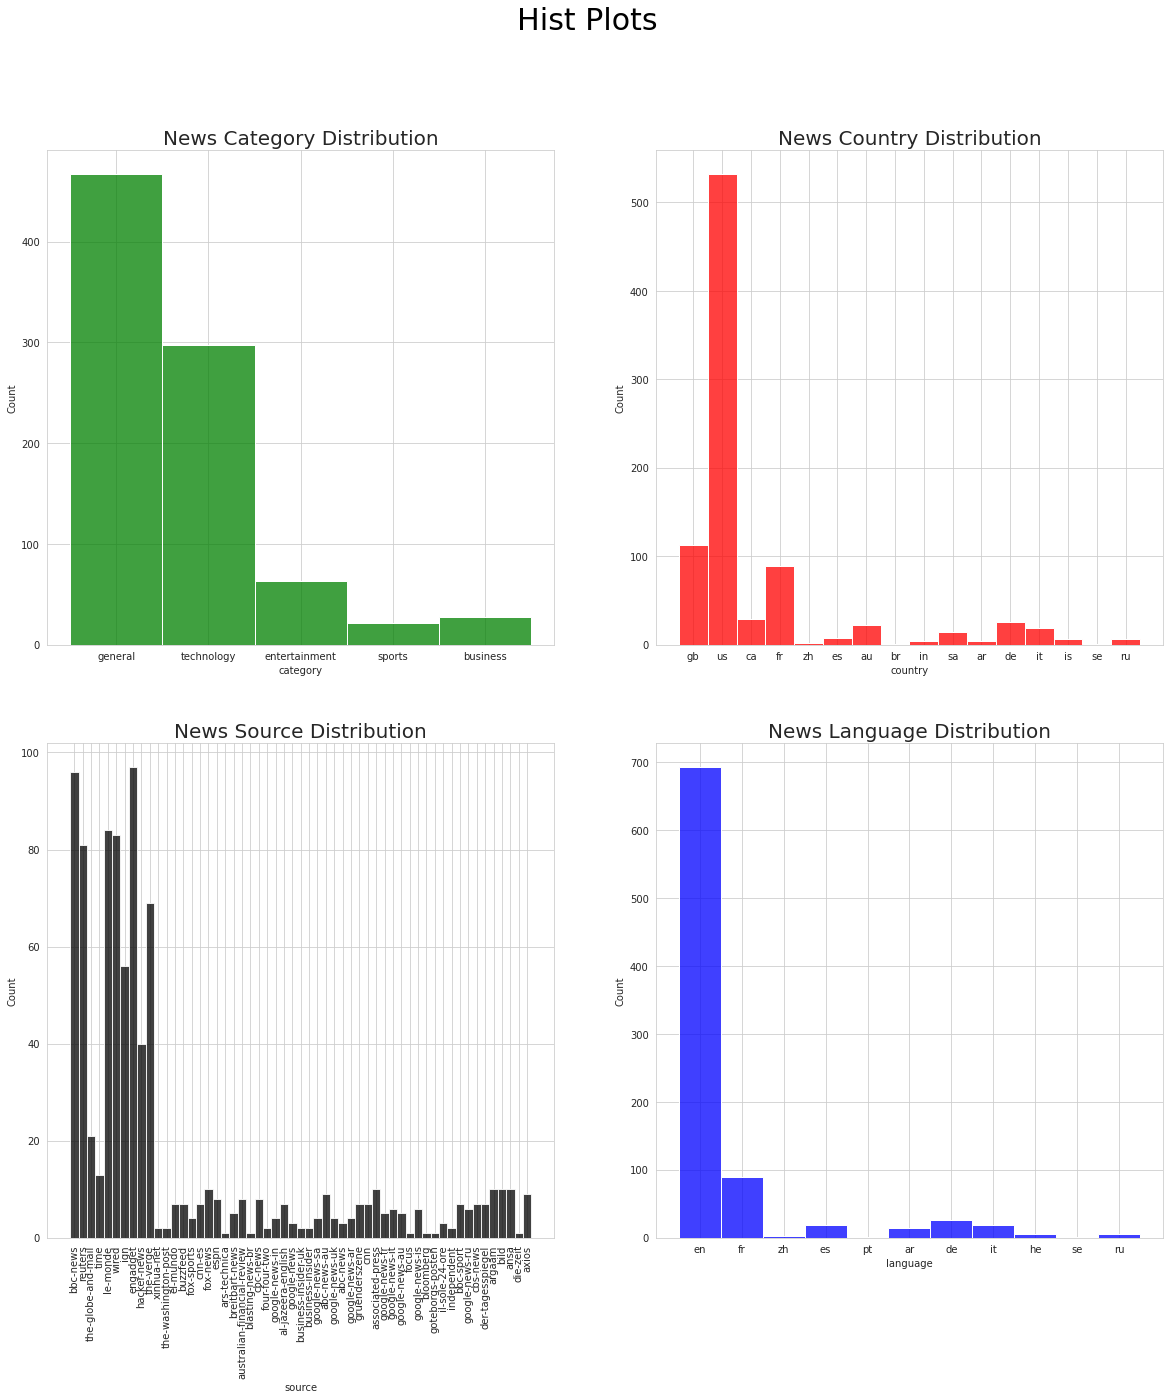

In [23]:
# Combined Subplots of Selected Features
plt.figure(figsize=(20,20)) # Set Size of Figure Template
plt.suptitle('Hist Plots',size=30) # Set Title of General plot and size
plt.subplots_adjust(wspace=0.2,hspace=0.2) # Adjust Width and Height Space Between Individual plots To prevent cluster among plots
sns.set_style('whitegrid')
plt.subplot(2,2,1) # First Subplot
plt.title('News Category Distribution',size=20) # First subplot title and size
sns.histplot(news_data.category,color='g') 
plt.subplot(2,2,2)
plt.title('News Country Distribution',size=20)
sns.histplot(news_data.country,color='r')
plt.subplot(2,2,3)
plt.title('News Source Distribution',size=20)
sns.histplot(news_data.source,color='k')
plt.xticks(rotation=90) # Rotates the XTicks Labels by 90 degrees
plt.subplot(2,2,4)
plt.title('News Language Distribution',size=20)
sns.histplot(news_data.language,color='b')


Text(0, 0.5, 'Count')

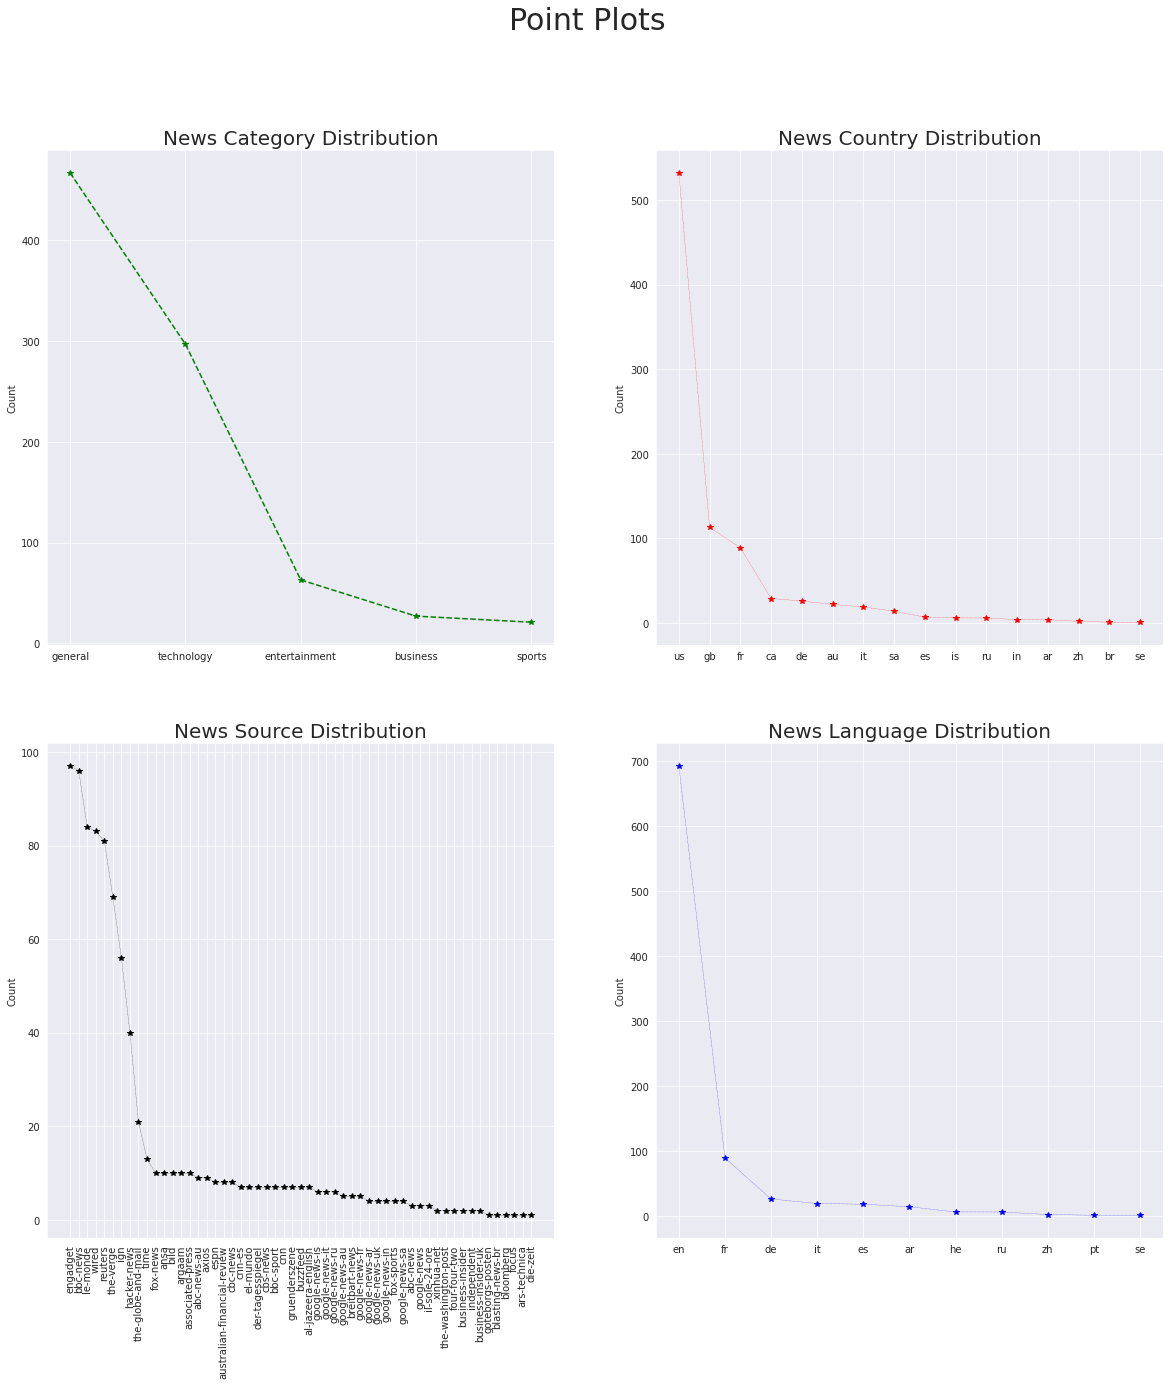

In [24]:
# Combined Subplots of Selected Features
plt.figure(figsize=(20,20)) # Set Size of Figure Template
plt.suptitle('Point Plots',size=30) # Set Title of General plot and size
plt.subplots_adjust(wspace=0.2,hspace=0.2) # Adjust Width and Height Space Between Individual plots To prevent cluster among plots
sns.set_style('darkgrid')
plt.subplot(2,2,1) # First Subplot
plt.title('News Category Distribution',size=20) # First subplot title and size
plt.plot(news_data.category.value_counts(),'g*--') 
plt.ylabel('Count')
plt.subplot(2,2,2)
plt.title('News Country Distribution',size=20)
plt.plot(news_data.country.value_counts(),'r*--',lw=0.25)
plt.ylabel('Count')
plt.subplot(2,2,3)
plt.title('News Source Distribution',size=20)
plt.plot(news_data.source.value_counts(),'k*--',lw=0.25)
plt.xticks(rotation=90) # Rotates the XTicks Labels by 90 degrees
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.title('News Language Distribution',size=20)
plt.plot(news_data.language.value_counts(),'b*--',lw=0.25)
plt.ylabel('Count')


The Plots above convey same information on different plots. The First is a histogram plot showing the number of distinct entries in selected categorical columns. The second is a line plot with a star marker that shows the number of distict entries in the selected features.

The Plots above shows the distribution of different features. There are several Languages of News in the Dataset of which English represented as 'en' is the most common and French represented as 'fr' is the next most common. Most of the data entries originates from news sources in the US as shown in the country plot. The General news category has the most entry in the News category, while sports has the least entry in the news category.

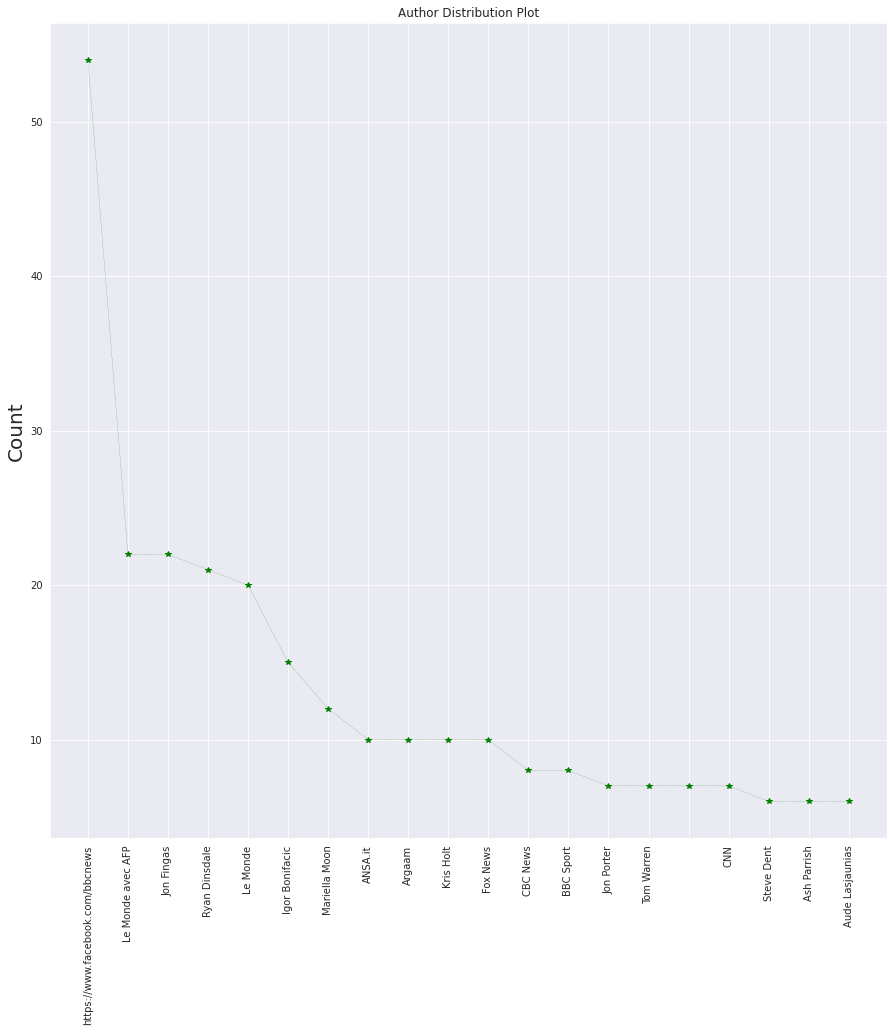

In [25]:
# A plot of the top 20 authors in the dataset
plt.figure(figsize=(15,15))
sns.set_style('darkgrid')
plt.xticks(rotation=90)
plt.title('Author Distribution Plot')
plt.ylabel('Count',size=20)
plt.plot(news_data.author.value_counts()[:20],'g*--',lw=0.2)

The author plot above shows the top 20 authors in the dataset. BBC news from facebook platform is the main source of news in the dataset.

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

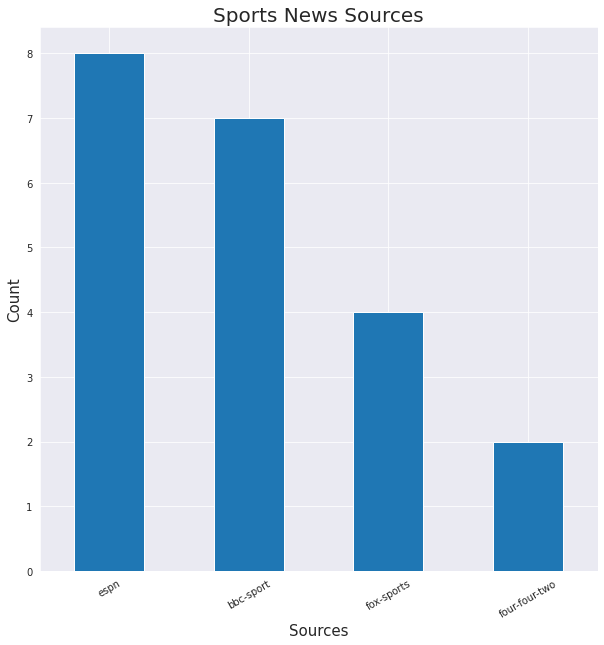

In [26]:
# Sources of Sports news in the data set
plt.figure(figsize=(10,10))
plt.title('Sports News Sources',size=20)
plt.ylabel('Count',size=15);plt.xlabel('Sources',size=15)
news_data.source[news_data['category'].isin(['sports'])].value_counts().plot(kind='bar') # Plot of Sources from Sports Category. Get the value counts and plots it uses bar plot
plt.xticks(rotation=30)


The Bar Plot above shows the Sources of Sports Data in the Dataset. There are 4 sports news channel, with ESPN having the most sports news in the set, followed closely by bbc-sports, fox-sports and four-four two news.

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

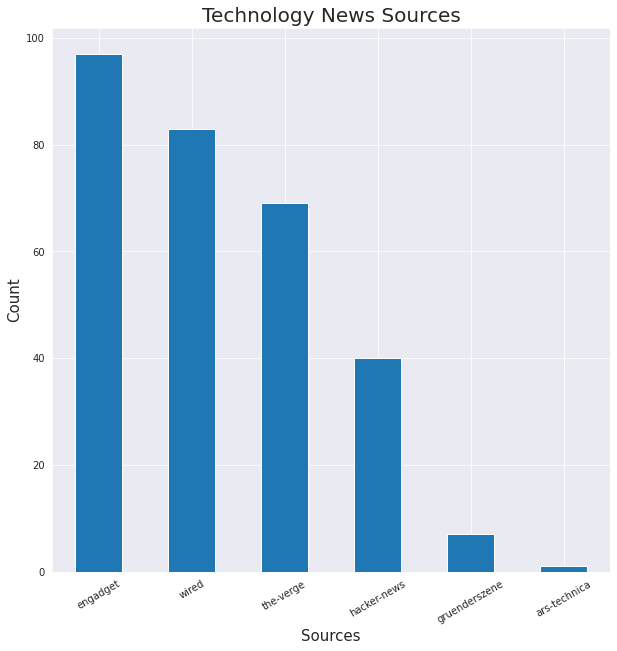

In [27]:
# Sources of Technology news in the data set
plt.figure(figsize=(10,10))
plt.title('Technology News Sources',size=20)
plt.ylabel('Count',size=15);plt.xlabel('Sources',size=15)
news_data.source[news_data['category'].isin(['technology'])].value_counts().plot(kind='bar') # Plot of Sources from Technology Category. Get the value counts and plots it uses bar plot
plt.xticks(rotation=30)

The Sources of Technology News are shown in the plot above. Major news sources such as CNN,BBC,Fox News are not seen in the plot above. This shows that Technology news mainly comes from Channels that are dedicated to broadcast Technology News.

##### **What is the news talking about during the selected month of February based on the fraction of the dataset that has been extracted?. What made headlines and what didnt. we will be analysing the text of the news at the word level. we want to get an insight into what most news sources were concerned about based on the way, manne and number of times key words were used. The title Column will be used for this analysis.**

### News Text Analysis

We Wish to analyze the words of the Text. we will select only english words. Clean the text, perform our analysis.

In [28]:
# Selecting Only English News from the News
news_eng_text=news_data[news_data.language.isin(['en'])]
news_text=news_eng_text.title.values # Extract the Title columns as a numpy column
news_text[:5]

array(["Winter Olympics: James Woods & the 'internal battle' when counter culture meets elite sport",
       'BUZZ COMMENT-RBA to end QE, revise forecasts and sound less dovish - Reuters',
       'Australia sovereign wealth fund reports slowdown in returns, tightens approach - Reuters',
       'Midsize law firm Michelman & Robinson opens in Houston weeks after Dallas launch - Reuters',
       "O'Toole faces caucus revolt as 35 MPs sign letter calling for leadership review vote - The Globe and Mail"],
      dtype=object)

Regular Expressions from the re library will be used to clean the text and remove unwanted characters. NLTK (Natural Library Tool Kit) is a python library used for text and semantic analysis, the NLTK library will be used for analysis and making important plots.

In [29]:
# Converting all uppercase entry to lowercase
news_text=[text.lower() for text in news_text] # This converts all uppercae enrry to lower case
news_text[:5]

["winter olympics: james woods & the 'internal battle' when counter culture meets elite sport",
 'buzz comment-rba to end qe, revise forecasts and sound less dovish - reuters',
 'australia sovereign wealth fund reports slowdown in returns, tightens approach - reuters',
 'midsize law firm michelman & robinson opens in houston weeks after dallas launch - reuters',
 "o'toole faces caucus revolt as 35 mps sign letter calling for leadership review vote - the globe and mail"]

In [30]:
# Splliting text using regular expressions
news_text=[re.split(r'[^a-z0-9]',text) for text in news_text] # This splits up each of the title text at any non alphanumeric character
news_text[-5:]

[['biden',
  's',
  'dilemma',
  '',
  'how',
  'to',
  'give',
  'putin',
  'an',
  'off',
  'ramp'],
 ['new', 'spacex', 'satellites', 'snarled', 'by', 'red', 'tape'],
 ['turkey',
  'rejected',
  'uyghur',
  'citizenship',
  'applications',
  'over',
  '',
  'national',
  'security',
  '',
  'risks'],
 ['scoop', '', 'specialty', 'lab', 'test', 'startup', 'scores', '', '20m'],
 ['ukrainian', 'sportsmen', 'sign', 'up', 'to', 'fight']]

The Regular Expression r'[^a-z0-9]' splits the text up at any chracter not alpha numeric i.e any character not in a-z or 0-9. The ^ serves as 'not in'. We use list comprehension to limit the number and lines of codes to be written.

Certain words can be considered uninformative because they convey no meaningful information. words that are less than three letters will be dropped from the text.

In [31]:
# Dropping words with length less than 3
news_text=[[word for word in text if len(word)>=3] for text in news_text]
news_text[-5:]

[['biden', 'dilemma', 'how', 'give', 'putin', 'off', 'ramp'],
 ['new', 'spacex', 'satellites', 'snarled', 'red', 'tape'],
 ['turkey',
  'rejected',
  'uyghur',
  'citizenship',
  'applications',
  'over',
  'national',
  'security',
  'risks'],
 ['scoop', 'specialty', 'lab', 'test', 'startup', 'scores', '20m'],
 ['ukrainian', 'sportsmen', 'sign', 'fight']]

Words with length less than 3 were dropped from the news text in the cell above, we consider them to be uninformative to our analysis e.g of such words are an,it,be e.t.c

Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document. Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc

Stopwords are genrally considered not to add much values to the meaning of documents. Stopwords are contained in the NLTK library as a word corpus.we will get the stopwords in the NLTK library and use them to select and drop the stopwords in the news text.

In [32]:
# Loading Stopwords from the NLTK library
nltk.download('stopwords') # Downloads Stopwords corpus from NLTK
stopwords=nltk.corpus.stopwords.words('english') # Selects only english Stopwords
stopwords[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

The output above shows the first 10 entries of the stopwords list from the NLTK library. The stopwords from the text will b dropped by comparing each word in the text with the content of the stopwords library, while still trying to maintain the sequence and order of the text.

In [33]:
# Removing stopwords From News Text
news_text=[[word for word in text if word not in stopwords] for text in news_text] # List Comprehension
news_text[-5:]

[['biden', 'dilemma', 'give', 'putin', 'ramp'],
 ['new', 'spacex', 'satellites', 'snarled', 'red', 'tape'],
 ['turkey',
  'rejected',
  'uyghur',
  'citizenship',
  'applications',
  'national',
  'security',
  'risks'],
 ['scoop', 'specialty', 'lab', 'test', 'startup', 'scores', '20m'],
 ['ukrainian', 'sportsmen', 'sign', 'fight']]

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word (nlp.stanford.edu). We will lemmatize the text using the default WordNet Lemmatizer in the NLTK library.

In [34]:
# Lemmatizing Text Data
nltk.download('wordnet') # Download Wordnet from NLTK library
lemma=nltk.stem.WordNetLemmatizer() # Initializing the WordNet Lemmatizer
news_text=[[lemma.lemmatize(word) for word in text] for text in news_text] # Lemmatize words in the text using list comprehension
news_text[-5: ]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


[['biden', 'dilemma', 'give', 'putin', 'ramp'],
 ['new', 'spacex', 'satellite', 'snarled', 'red', 'tape'],
 ['turkey',
  'rejected',
  'uyghur',
  'citizenship',
  'application',
  'national',
  'security',
  'risk'],
 ['scoop', 'specialty', 'lab', 'test', 'startup', 'score', '20m'],
 ['ukrainian', 'sportsman', 'sign', 'fight']]

The text will be flattened into a single list of words. then convert the list of words into a NLTK words corpus to enable us use some of its methods and functions.

In [35]:
# Flattening the words
news_words=[word for text in news_text for word in text] # Turning words in a long list of texts
# Converting Words to NLTK Text
news_words=nltk.Text(news_words) # Converting text into a NLTK words corpus
news_words[-5:]

['20m', 'ukrainian', 'sportsman', 'sign', 'fight']

The text has been cleaned and turned into an NLTK word corpus. we will try to gain insight into most common words and phrases in the news text data.

In [36]:
# Frequency Distribution to show the number of words occurence
freq_dist=nltk.FreqDist(news_words) # Gets the unique words and their counts and puts them into a dictionary.
print('Number of words in the text is: {}'.format(freq_dist.N()))
print()
freq_dist.tabulate(50)

Number of words in the text is: 5274

  reuters   ukraine       new    russia      game       say       ask   russian     globe      mail      year     covid     super       war     putin      news      west     could     world       win  olympics      bowl      make     video      call      2022   release     apple    hiring      best       hit     month      amid      deal     first       day      find microsoft    google  nintendo       end      firm      time     china    border      live      take      want       one      open 
       82        52        43        39        27        27        27        22        21        21        17        17        16        16        15        15        14        13        13        13        12        12        11        11        11        11        11        11        11        11        10        10        10        10        10        10        10        10        10        10         9         9         9         9         9         9  

The Output above shows the number of occurence of top 50 words in the text. This will be plotted to gain better insight into it.

There are 5274 words in the text we will make a plot of the first 30 words in the news data

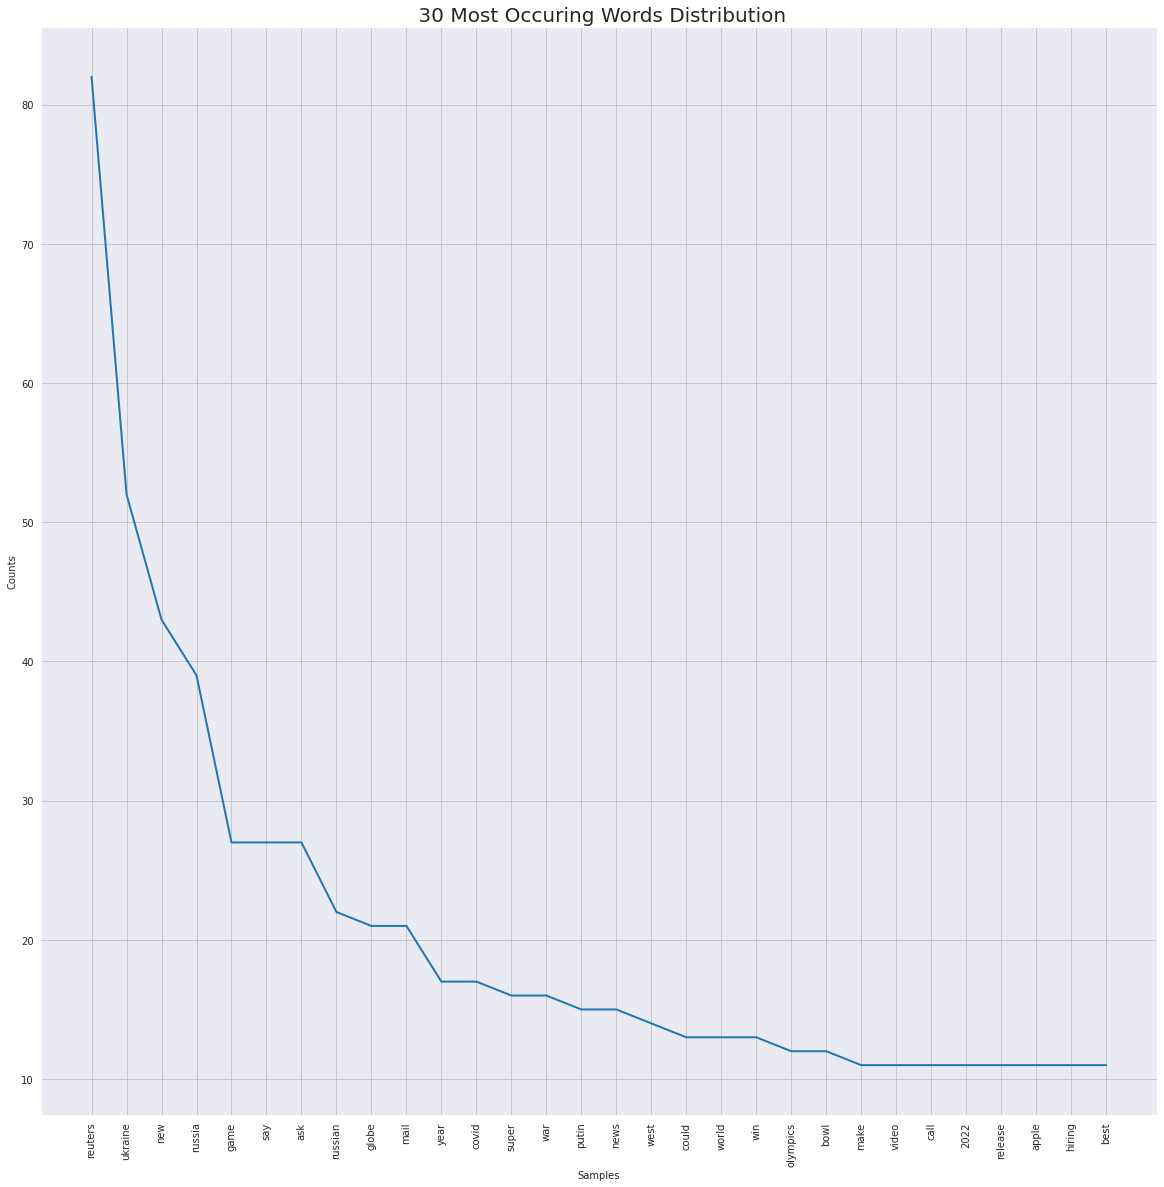

In [45]:
# A Plot of the first 30 most occuring words in the dataset
plt.figure(figsize=(20,20))
plt.title(' 30 Most Occuring Words Distribution',size=20)
freq_dist.plot(30) # A Plot of the Words.

A Plot of the occurence of the most occuring words in the text.

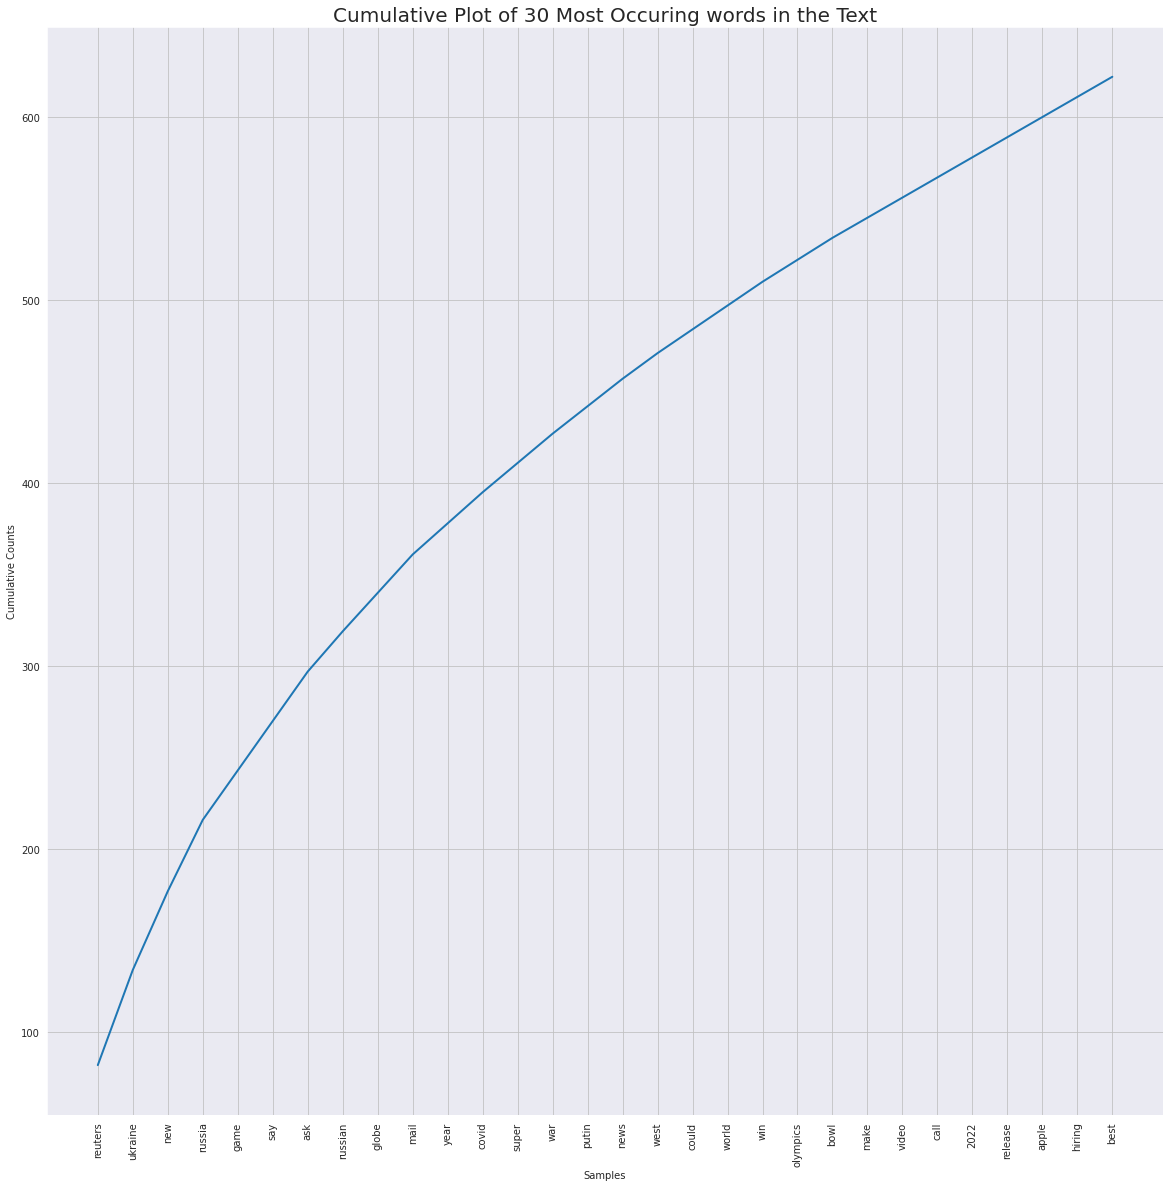

In [46]:
# Cumulative Plot of Top 30 Most common words in the text
plt.figure(figsize=(20,20))
plt.title('Cumulative Plot of 30 Most Occuring words in the Text',size=20)
freq_dist.plot(30,cumulative=True) # A Cumulative plot of Freq Dist Plot.

The Plots above shows the Occurence of the most common words in the text ranked in decreasing order of occurence. The second plot is a cumulative plot of the number of Top 30 words.

The Most common word in the Text is 'reuters', this is the name of one the news sources,this likely indicates that the reuters news source inputs its name as part of its text news so this can be considered uninformative, several other uniformative words appear also as top occuring words,words such as , new,say,ask,mail,year,could,call are also considered uniformative.

The top informative words in the news text in decreasing order of magnitude include
1. Ukraine: occuring 52 times
2. Russia : occuring 39 times
3. Russian: occuring 22 times
4. Covid: occuring 17 times
5. Super: occuring 16 times
6. War: occuring 16 times
7. Putin: occuring 15 times
8. West: occuring 14 times
9. Olympics: occuring 12 times

Other words can also be found on the plot.

The Cumulative plot of the top 30 words in the text shows that that the top 30 words has approximately 650 words out of the 5274 total words in the text.

Note 1: The News data was sourced  and ranked by popularity from the News API.The fraction of dataset used in this analysis represnt the most popular news in the month of february. These news shows what mattered most to the news sources and channels.

Note 2: The titles of each news entry were used for analysis as stated earlier. The titles are short sentences summarizing the news. There is little or no probablity of a word repeating itself in same news entry. 

The top occuring words in the plot as listed above can be broadly grouped into three categories of news and we can consider these to be the top issues that made headlines for the news sources in the month of February based on the fraction of news data we extracted.

1. ukraine-Russia Conflict: Issues concerning this conflict can be seen to make the most headline, with Ukraine been the most mentioned word in the dataset, Russia, Russian Putin,West War appearing among the top 10 occuring words in the news text. The Context in which the word 'war' was used will be explored further to certainly define the context in which it was used in the text. same as the word 'west'.

2. Covid: Covid as a word was among the top 5 informative most common words used, that is to say that as at February 2022 Covid remains a headline in most of the major news sources.

3. Super/Olympics: The word Super appears as among the top five informative most informative words in the news text. This may likely refer to super bowl but the context in which the word Super was used will be explored further. Olympics also appears as among the top occuring words in the news. Both words fall under the Sports Category.


######**Looking at the context Certain Selected words were used.** 

In [39]:
# The word 'War'
news_words.concordance('war') # Gets all the Context and sentences the word War was used

Displaying 16 of 16 matches:
ance ukraine could result russia nato war globe mail google one vpn finally ava
onising wait news five year old world war two nazi guard son find propaganda lo
d olympics wore mask game ipad tablet war republic ireland fa abandon 2030 worl
super bowl ukraine tension eight year war eastern city unifies russia russian t
l pulling russia dumping gazprom deal war crime investigation underway ukrainia
 could bring end putin russia ukraine war australia biggest russia investor pac
ne creating spike energy price tucker war could get much worse already fifa uef
hip strait amid russia ukraine crisis war ukraine major source uncertainty say 
a two russian oligarch call end putin war wheat energy price spike amid fear fr
madness bracket selection drama photo war spare ukraine child hannity call russ
ia intervention provided hint ukraine war rba patient ukraine war led inflation
 hint ukraine war rba patient ukraine war led inflation spike manchester united
dom square 

A look at the sentences above shows portions of the general news text where the word 'War' was used. It can be seen that the word was generaly and mainly exclusively used with other words such as Ukraine,Russia, Putin. and generally partains to the crises in eastern Europe. so we can conclusively say that the word 'War' in the context of the Ukraine-Russia crises was used by various news outlet during the month of February based on the fraction of the dataset collected.

In [40]:
# The word 'Super'
news_words.concordance('super') # Gets all the Context and sentences Super was used

Displaying 16 of 16 matches:
ut january behind reuters seven time super bowl winner nfl legend brady retires
verse reuters cincinnati school call super bowl timeout reuters parte seizure o
orld top 100 asked join saudi funded super league mickelson omicron know covid 
ast pixel security update amazon new super bowl feature creepy mind reading ale
hains new national economy metaverse super fast battery charging fix electric c
es first race winter gut bahrami win super gold skating star valieva positive d
rocrastination please help way watch super bowl 2022 hitting book crop diversit
be mail cryptocurrency advert taking super bowl ukraine tension eight year war 
promise artificial hymen stream 2022 super bowl puppy bowl ride safely propella
t trailer lord ring ring power debut super bowl ortiz nailed beer ace scheffler
ung skater failed drug test polestar super bowl take jab tesla new york time ma
dified playstation xbox ad dominated super bowl expect buy one anytime soon let
apologizes 

The word super bowl was among most of the most used words in the text as earlier seen. the cell above list outs The portions of the text the word 'super' was used, and it can be seen that the word 'super' was always followed by the word 'bowl' . This shld be in refrence to the American super bowl that took place during the month of match.We can confidently conclude that the Super Bowl event was a major talking point for major selected news headlines during the month of February based on the fraction of News Text we extracted.

In [41]:
# The word 'West'
news_words.concordance('west') # Gets all the Context and sentences West was used

Displaying 14 of 14 matches:
uble recovers past dollar eye russia west talk reuters emerging currency book 
ance shape reality india beat feeble west indie six wicket opening odi seis w2
rprise aloy outfit horizon forbidden west bandai namco spend 130 million metav
an nazi party wait horizon forbidden west play something weird garmin instinct
rof ps4 owner play horizon forbidden west short clip split bill friend faceboo
cused sea blockade horizon forbidden west dozen accessibility setting research
eview reminder buy horizon forbidden west ps5 get ps4 instead formula great cu
ognition ukrainian feeling abandoned west warning imminent russian invasion mu
bull meaning essay horizon forbidden west getting tallneck lego set fbi say bl
ng minute delivery horizon forbidden west developer working fixing various vis
tation vr2 headset horizon forbidden west open world right best kid headphone 
ding putin unbalanced cagily preying west fear former soldier object answering
in intelligence officer

The cell above shows the portions of the total news text the word west' were used as it was one of the most occuring words in the text. The word 'west' was mostly preceded by 'Horizon forbidden'. according to wikipedia, Horizon Forbidden West is a 2022 action role-playing game developed by Guerrilla Games and published by Sony Interactive Entertainment. A sequel to 2017's Horizon Zero Dawn, it is an open world single-player video game set in a post-apocalyptic version of the Western United States.
This shows that the video game "horizon Forbidden West' was a major topic above among major news outlet based on the fraction of the dataset collected. 

Note 3: The Datset was sorted by date published. Therefore the words were also sorted according to date published.

A Lexical Dispersion Plot is a plot that shows the dispersion of selected word(s), it shows the points of occurence of the words in the text, we can use the information to determine the manner and usage of words over the period the data was collated. 

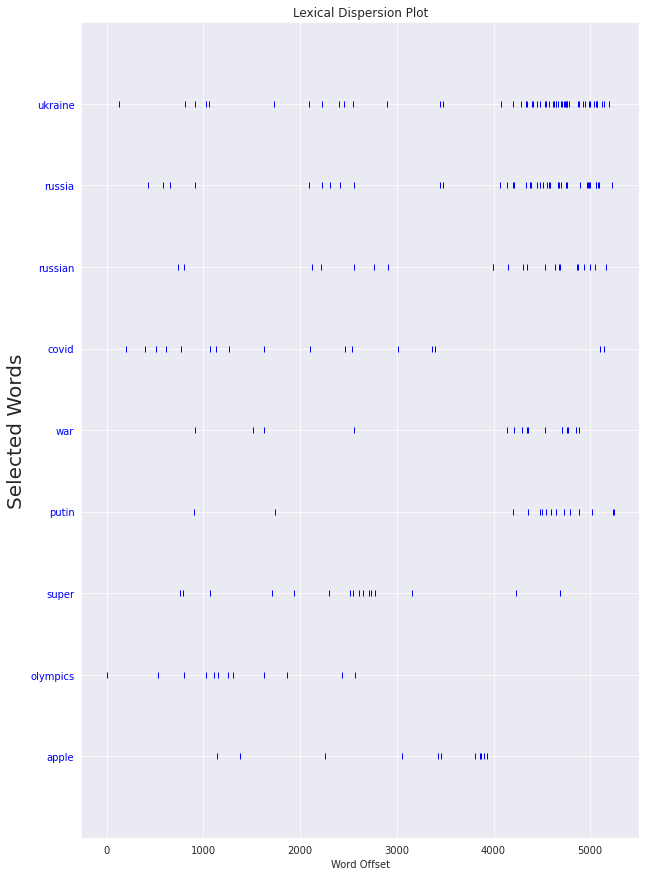

In [42]:
plt.figure(figsize=(10,15))
plt.ylabel('Selected Words',size=20)
news_words.dispersion_plot(['ukraine','russia','russian','covid','war','putin','super','olympics','apple']) # A Litst of Selected words to get the dispersion plot

The Figure above shows the Dispersion plot of selected words.

A look at the words 'Ukraine','Russia','Russian','war','putin' shows that they were densely used towards words offset of above 4000. This means they became more frequently used towards the end of the news words list, this list was sorted in order of Date Published with earliest dates first.
Therefore we can say that the importance of the subject pertaining to these words was a major talking point towards the end of the month of February, this is supported by the plot of Ukraine and Russia been densely used towards the end of the sort text. the plot above shows that these were mainly the only words used towards the end of the text(>4000 word offset) other topics were put on hold.

The word Covid from the plot above was used at the same rate through out the period of February which the data was collected.

Olympics was a word used during the beggining of the month of march through to the middle, but was largely not used towards the end of the month of march based on the dfraction of Dataset collected.

In [43]:
#A Look at Collocations in the text.
news_words.collocations()

globe mail; super bowl; horizon forbidden; forbidden west; cbc news;
activision blizzard; pok mon; galaxy s22; legend arceus; facial
recognition; joe rogan; cbs news; ukraine tension; disney warner;
daily horoscope; reuters com; horoscope february; elden ring; wall
street; w21 hiring


The Cell above shows collocations in the text. collocations are words that occur together(side by side) Multiple times in a text.

### **SUMMARY**

We Analyzed the news headlines from major news sources ranked in order of popularity for the month of February. Sourced from NEWSAPI. Based on the fraction of data collected, the headlines and issues from the news sources in the month of February are : 

1. Ukraine-Russian Crises (Predominant)
2. Covid
3. Super Bowl/Olympics

### Challenges faced in collecting Data from API.

The NEWSAPI is Paginated and also a rate limited API. It allows just 100 request per 24 hours for a developers account and totally blocks a developer from further extracting data after a number of requests have been made.It returns a total of 20 articles per each page of request. Getting the data took weeks and still not too many data could be gotten from the API because of these restriction. 

The API is irregular in creating new sessions for request using a developers account after a 24 hour window.

### Ideas on Further Analysis

The following are list of analysis that can be explored further,
1. The Dataset can be grouped into countries using the country column and analysed then the topics specfic to each country or selected countries can be ascertained and determined.
2. The Description column offers more information above a news entry than the title column which was used in text analysis. Same analysis can be performed using the description feature/columns and conclusions drawn from it, the conclusion can be compared with that gotten from using the ttitle column/feature for analysis.
3. Technology and other category news can be explored further to determine the major sources  and languages of these categories of news in the dataset.